# Assignment 6 - Answer

1 

Load fetch_lfw_people from sklearn.datasets

perform naives bayesian, logistic regression,

svm, knn, random forest, and ensemble bagging of svm classification

compare them based on 

 1) precision-recall curve, 

 2) Grid search time (if any, e.g., SVM, KNN, trees)

 3) fit time 


Of course, as all data scientist do, we usually like to examine

the nature of our data, e.g., whether our data is imbalanced, 

how many features, perhaps try display one image, etc.


Discuss why do you think that particular model works well or does not

work well for this data.

=====Balance check====
Colin Powell sample:  236
Donald Rumsfeld sample:  121
George W Bush sample:  530
Gerhard Schroeder sample:  109
Tony Blair sample:  144
Picture of:  Colin Powell
Picture of:  George W Bush
Picture of:  Colin Powell
Picture of:  George W Bush
Picture of:  George W Bush
Picture of:  George W Bush


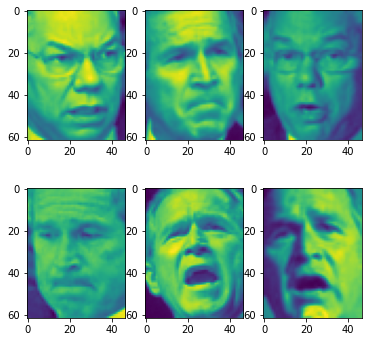

In [1]:
from sklearn.datasets import fetch_lfw_people
# Your code here
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

#default resize is 0.5
#I have made it smaller
lfw_people = fetch_lfw_people(min_faces_per_person=100)

X = lfw_people.data  #already mesh height x width into one
y = lfw_people.target

#(1288, 2914)
n_samples, n_features = X.shape

##make sure X and y shape matches
assert n_samples == y.shape[0]

#image shape.  Can be used for plotting
_, height, width = lfw_people.images.shape

#check how many classes there are
n_classes = len(set(y))
assert n_classes == lfw_people.target_names.shape[0]

#check whether data is imbalanced
#clearly imbalanced!!
print("=====Balance check====")
for i in range(n_classes):
    print(f"{lfw_people.target_names[i]} sample: ", (y[y==i]).shape[0])

#let's plot some image of these people
def plot_image_randomly(X, y, height, width, n_random):
    plt.figure(figsize=(6, 6))
    #reshape into (height, width) for imshow
    for i in range(1, n_random+1):
        plt.subplot(int(np.ceil(n_random/3)), 3, i)
        ix = np.random.randint(X.shape[0])
        print("Picture of: ", lfw_people.target_names[y[ix]])
        plt.imshow(X[ix].reshape(height, width))
    
plot_image_randomly(X, y, height, width, n_random=6)


In [2]:
#Ok, now we finish examining a bit of our data
#let's first split things
# split into a training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [3]:
#copy plot_pr_curve from my lecture
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#add title param
def plot_pr_curve(y_test, y_score, title):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test, y_score,
                                                         average="micro")    

    plt.plot(recall["micro"], precision["micro"], ":",
            label=f"micro average (area = {average_precision['micro']:.2f})")

    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f"Precision-Recall curve of class {i} (area = {average_precision[i]:.2f})")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")

Fit time: 0.02
Predict time: 0.03


'\nWell, images are far from guassian (normal) distribution, thus\nthis not gonna work well with GNB assumption\n'

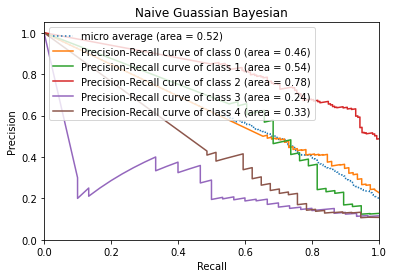

In [4]:
#Bayesian
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.preprocessing import label_binarize

model = GaussianNB()

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Naive Guassian Bayesian")

'''
Well, images are far from guassian (normal) distribution, thus
this not gonna work well with GNB assumption
'''

Fit time: 20.96
Predict time: 0.01


"\nWell, images are input pixels that are linearly combined, thus deriving\nthe output by shifting a linear equation inside sigmoid should perform\npretty well.  Again, it's all about meeting model assumption.\n\nHowever, if you compare LR with other algorithms, fit time is relatively\nmuch longer than other algorithms, likely due to the learning process. \nAnyhow, if we take into account that SVM or RF who achieve similar \naccuracy require long time in finding the right hyperparameters through GridSearchCV,\nit becomes clear that LR is the winner here.\n"

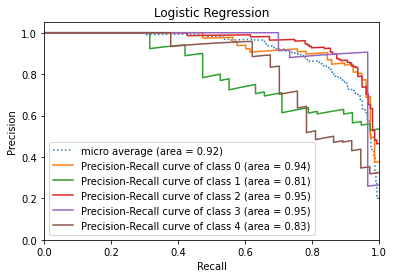

In [5]:
#LR
from sklearn.linear_model import LogisticRegression

#put max_iter to remove the annoying convergence warning
model = LogisticRegression(multi_class="ovr", max_iter=3000,
                          n_jobs=-1)

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Logistic Regression")

'''
Well, images are input pixels that are linearly combined, thus deriving
the output by shifting a linear equation inside sigmoid should perform
pretty well.  Again, it's all about meeting model assumption.

However, if you compare LR with other algorithms, fit time is relatively
much longer than other algorithms, likely due to the learning process. 
Anyhow, if we take into account that SVM or RF who achieve similar 
accuracy require long time in finding the right hyperparameters through GridSearchCV,
it becomes clear that LR is the winner here.
'''

Grid search uses time: 14.52
The best parameters are {'n_neighbors': 7} witha score of 0.62
Fit time: 0.08
Predict time: 0.31


'\nWell...KNN has assumption similar to guassian distribution, i.e.,\nthings nearer to it should share similar features.  Unfortunately,\nthat is not true with images....especially very similar images like\nface.\n\nIn additoin, KNN does not perform any "learning", and thus it may perform\nrelatively worse than other "learning" models such as SVM or logistic\nregression who can learn to fine-tune their weights for complicated\nfeatures\n\nAlso, as expected, predict time takes much more time\nthan fit time, since prediction time is the actual time \nto find the distance of nearby neighbors and sort them....\n'

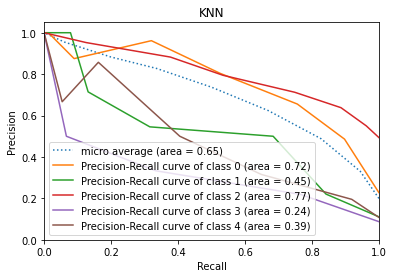

In [6]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_jobs=-1)
param_grid = {"n_neighbors": np.arange(2, 10)}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "KNN")

'''
Well...KNN has assumption similar to guassian distribution, i.e.,
things nearer to it should share similar features.  Unfortunately,
that is not true with images....especially very similar images like
face.

In additoin, KNN does not perform any "learning", and thus it may perform
relatively worse than other "learning" models such as SVM or logistic
regression who can learn to fine-tune their weights for complicated
features

Also, as expected, predict time takes much more time
than fit time, since prediction time is the actual time 
to find the distance of nearby neighbors and sort them....
'''

In [7]:
##Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = {"n_estimators": [10, 50, 100], 
              "criterion": ["gini", "entropy"],
              "max_depth": np.arange(1, 10),
              "class_weight": ["balanced_subsample", None]}

#put -1 so it gonna use all of my pc cores....
#randomforest can be parallerized thus it supports this feature
model = RandomForestClassifier(n_jobs=-1)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Random Forest")

'''
Well, random forests is quite robust.  Given unlimited depth of
trees, you can imagine it can draw infinite straight line just
to partition the results.  Here the best param is max_depth = 9,
and number of trees = 100....but the fit time is quite little!
Also since images are pixel-based, I can imagine drawing many 
lines can help.  

However, since RF doesn't have any learning, it may perform worst
than LogisticRegression or SVM.  But even that, without learning,
Random forest is quite impressive. 

One drawback of RF is that it requires great amount of time
to find the right parameters as seen as the GridSearch time

'''

KeyboardInterrupt: 

In [ ]:
##SVM
from sklearn.svm import SVC # "Support vector classifier"

kernel = ['linear', 'rbf', 'poly']
C_range = [1, 5, 10, 50]
gamma_range = [0.0001, 0.0005, 0.001, 0.005]

param_grid = dict(gamma=gamma_range, C=C_range, 
                  kernel=kernel)

#class_weight='balanced' helps adjust the weight
#sometimes work well for imbalanced dataset
model = SVC(class_weight="balanced")

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.decision_function(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "SVM")

'''
SVM always take long long time!!! to find the right param. But once it identify 
the right param, the fit and prediction time is relatively less....since it only use few
support vectors to determine the class. SVM also benefits from kernel 
trick as well as the learning process

Kernel is poly thus likely the features are of polynomial degree
Gamma is 0.0001 which is quite now, so we can assume
the hyperplane is quite straight.  As for C which is also
not that large, it means that our hyperplane also has large
margin with the support vectors, which again, suggesting that
the data is linearly separable on the polynomial space

One unexpected thing is that LR beats SVM in terms of accuracy.  The possible explaination
is that most of the features are linearly combined and thus
descent algorithms can eventually find the better weights
'''


In [ ]:
#let's try ensemble of SVC
#I hope that it gonna improve accuracy by little
#but through the process of boostraping, it will reduce
#the time of SVC

from sklearn.ensemble import BaggingClassifier

kernel = ['linear', 'rbf', 'poly']
C_range = [1, 5, 10, 50]
gamma_range = [0.0001, 0.0005, 0.001, 0.005]
n_estimators = [10, 50, 100]

param_grid = dict(base_estimator__gamma=gamma_range, 
                  base_estimator__C=C_range, 
                  base_estimator__kernel=kernel,
                  n_estimators=n_estimators)

#boostraping only 10% for each estimator
#similar to above, we gonna make sure the weights are balanced
model = BaggingClassifier(SVC(class_weight="balanced"), max_samples=0.3)

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)
start = time()
grid.fit(X_train, y_train)
print(f"Grid search uses time: {(time() - start):.2f}")

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

model = grid.best_estimator_

start = time()
model.fit(X_train, y_train)
print(f"Fit time: {(time() - start):.2f}")

start = time()
y_score = model.predict_proba(X_test)
print(f"Predict time: {(time() - start):.2f}")

#plot precision recall curve
#recall that pr curve expects a binary class input
binarize_y = label_binarize(y_test, classes=np.arange(5))
assert binarize_y.shape == y_score.shape
plot_pr_curve(binarize_y, y_score, "Ensemble of SVC")

'''
Well, ensemble of svc comes with a price of long time doing GridSearch.
Fitting time and prediction time also took relatively longer.
Basically use ensemble of SVM only if you think 1% increase in accuracy matters!

#don't shift-enter this again, Chaky!

'''

2
Compare time and validation score of randomized search and grid search

For optimizing hyperparameters using the following params

specify parameters and distributions to sample from

<code>param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}
</code>


'''
What do you think?  Should we use RandomizedSearchCV?
'''

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

X, y = load_digits(return_X_y=True)
model = SGDClassifier(loss='hinge', penalty='elasticnet',
                   fit_intercept=True)

# param_dist = {'average': [True, False],
#               'l1_ratio': stats.uniform(0, 1),
#               'alpha': loguniform(1e-4, 1e0)}

'''
What do you think?  Should we use RandomizedSearchCV?
'''

In [ ]:
# Your code here
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier

import numpy as np

# get some data
X, y = load_digits(return_X_y=True)

# build a classifier
clf = SGDClassifier(loss='hinge', penalty='elasticnet',
                    fit_intercept=True)

# specify parameters and distributions to sample from
param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
print("Score: ", random_search.best_score_)
print("Best params: ", random_search.best_params_)

# use a full grid over all parameters
param_grid = {'average': [True, False],
              'l1_ratio': np.linspace(0, 1, num=10),
              'alpha': np.power(10, np.arange(-4, 1, dtype=float))}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print("Score: ", grid_search.best_score_)
print("Best params: ", grid_search.best_params_)



3.

3.

implement a linear SVM from scratch using mini-batch-gradient descent

implement the **primal** form (not dual form)

The loss function is as follows:

$$c(x, y, f(x)) = (1 - y * f(x))_+$$

$c$ is the loss function, $x$ the sample, $y$ is the true label, $f(x)$ the predicted label.

This means the following:
$$
c(x, y, f(x))= 
\begin{cases}
    0,& \text{if } y*f(x)\geq 1\\
    1-y*f(x),              & \text{else}
\end{cases}
$$

So consider, if y and f(x) are signed values $(+1,-1)$:

<ul>
    <li>the loss is 0, if $y*f(x)$ are positive, respective both values have the same sign.</li>
    <li>loss is $1-y*f(x)$ if $y*f(x)$ is negative</li>
</ul>

#### Objective Function 

As we defined the loss function, we can now define the objective function for the svm:

$$\underset{w}{min}\ \lambda\parallel w\parallel^2 + \ \sum_{i=1}^n\big(1-y_i \langle x_i,w \rangle\big)_+$$

As you can see, our objective of a svm consists of two terms. The first term is a regularizer, the second term the loss. The regularizer balances between margin maximization and loss. To get more informations I advice you the tutorial introduction of the above adviced Schölkopf & Smola book.

#### Derivatives

To minimize this function, we need the gradients of this function.

As we have two terms, we will derive them seperately using the sum rule in differentiation.

$$
\frac{\delta}{\delta w_k} \lambda\parallel w\parallel^2 \ = 2 \lambda w_k
$$

$$
\frac{\delta}{\delta w_k} \big(1-y_i \langle x_i,w \rangle\big)_+ \ = \begin{cases}
    0,& \text{if } y_i \langle x_i,w \rangle\geq 1\\
    -y_ix_{ik},              & \text{else}
\end{cases}
$$

This means, if we have a misclassified sample $x_i$, respectively $y_i \langle x_i,w \rangle \ < \ 1$, we update the weight vector w using the gradients of both terms, if $y_i \langle x_i,w \rangle \geq 1$ we just update w by the gradient of the regularizer. To sum it up, our stochastic gradient descent for the svm looks like this:

if $y_i⟨x_i,w⟩ < 1$:
$$
w = w + \eta (y_ix_i - 2\lambda w)
$$
else:
$$
w = w + \eta (-2\lambda w)
$$



one thing you need to be aware is that svm expect your y

to be -1 and 1, not 0 or 1, or 1 or 2.

last, get_pred should be np.sign(X @ w)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#generate quite a lot of noise
#with only 4 informative features out of 10
#with 2 redundant features, overlapping with that 4 informative features
#and 4 noisy features
#Also, make std wider using n_clusters=2
X, y = make_classification(n_samples=500, n_features=10, n_redundant=2, n_informative=4,
                             n_clusters_per_class=2, random_state=14)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#look at the data...it is likely not linearly separable!

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score, classification_report

def mini_batch_GD(X, y, max_iter=1000):
    w = np.zeros(X.shape[1])
    l_rate = 0.00001
    batch_size = int(0.1 * X.shape[0])
    for i in range(max_iter):
        ix = np.random.randint(0, X.shape[0])
        batch_X = X[ix:ix+batch_size]
        batch_y = y[ix:ix+batch_size]
        #becareful the sign is "+" l_rate since i have already inverted 
        #the sign in gradient()
        for i, x in enumerate(batch_X):
            w = w + l_rate * gradient(batch_X[i], batch_y[i], w)
    return w, i

def gradient(x, y, w):
    lamb = 0.01
    if (y * (x @ w)) < 1:
        return (x * y) + (-2 * lamb * w)
    else:
        return -2 * lamb * w
        
def get_pred(X, w):
    #use np.sign if our input y is -1 and 1
    return np.sign(X @ w)

#transform our y to be -1 and 1 to meet svm purpose
y_train_minus = y_train.copy()
y_test_minus = y_test.copy()
y_train_minus[y_train_minus==0] = -1
y_test_minus[y_test_minus==0] = -1

#if the training data is not scaled properly,
#since svm is a widest street algorithm, SVM will tend 
#to neglect small features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

w, i = mini_batch_GD(X_train_standardized, y_train_minus, max_iter=10000)
pred = get_pred(X_test_standardized, w)

print("APS: ", average_precision_score(y_test_minus, pred))
print("Report: ", classification_report(y_test_minus, pred))



4. 


Modify the scratch code of KNN in lecture 9.4 to include the following capabilities:
    <ol>
        <li>If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider</li>
        <li>Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors</li>
        <li>Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range</li>
        <li>Put everything into a class <code>KNN</code>.  It should have at least two methods, <code>fit(X_train, y_train)</code>, and <code>predict(X_test)</code></li>
    </ol>
</font>

5. 


Modify the scratch code of Decision Tree in lecture 9.4 to include the following capabilities:
    <ol>
        <li>Put everything into a class <code>DecisionTree</code>.  It should have at least two methods, <code>fit(X_train, y_train)</code>, and <code>predict(X_test)</code></li>
    </ol>
</font>

6.

Modify the Bagging code in Lecture 9.5 such that it also produces out-of-bag evaluation score

In [38]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                test_size=0.3, shuffle=True, random_state=42)

In [39]:
from sklearn.tree import DecisionTreeClassifier
import random
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score

B = 5
m, n = X_train.shape
boostrap_ratio = 1
tree_params = {'max_depth': 2, 'criterion':'gini', 'min_samples_split': 5}
models = [DecisionTreeClassifier(**tree_params) for _ in range(B)]

#sample size for each tree
sample_size = int(boostrap_ratio * len(X_train))

xsamples = np.zeros((B, m, n))
ysamples = np.zeros((B, m))

xsamples_oob = []  #use list because length is not known
ysamples_oob = []

#subsamples for each model
for i in range(B):
    ##sampling with replacement; i.e., sample can occur more than once
    #for the same predictor
    oob_idx = []
    for j in range(sample_size):
        idx = random.randrange(m)
        oob_idx.append(idx)
        xsamples[i, j, :] = X_train[idx]
        ysamples[i, j] = y_train[idx]
    mask = np.zeros((m), dtype=bool)
    mask[oob_idx] = True
    xsamples_oob.append(X_train[~mask])
    ysamples_oob.append(y_train[~mask])
    
#fitting each estimator
oob_score = 0
for i, model in enumerate(models):
    _X = xsamples[i, :]
    _y = ysamples[i, :]
    model.fit(_X, _y)
                        
    #calculating oob score
    _X_test = np.asarray(xsamples_oob[i])
    _y_test = np.asarray(ysamples_oob[i])
    yhat = model.predict(_X_test)
    oob_score += accuracy_score(_y_test, yhat)
    print(f"Out of bag score tree {i}", accuracy_score(_y_test, yhat))
    
print("Average out of bag score: ", oob_score /len(models))
           
#make prediction and return the probabilities
predictions = np.zeros((B, X_test.shape[0]))
for i, model in enumerate(models):
    yhat = model.predict(X_test)
    predictions[i, :] = yhat
        
yhat = stats.mode(predictions)[0][0]

print(classification_report(y_test, yhat))

Out of bag score tree 0 0.926829268292683
Out of bag score tree 1 0.868421052631579
Out of bag score tree 2 0.9487179487179487
Out of bag score tree 3 0.926829268292683
Out of bag score tree 4 0.9
Average out of bag score:  0.9141595075869787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



7.

Modify the code from (4) to randomize features in each split step, thus becoming Random Forests.

Here, instead of using sklearn version of Decision Trees, you may want to use your own scratch version of DecisionTree, so you can modify how split are done.

In [40]:
from sklearn.tree import DecisionTreeClassifier
import random
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score

B = 5
m, n = X_train.shape
boostrap_ratio = 1
tree_params = {'max_depth': 2, 'criterion':'gini', 'min_samples_split': 5}
models = [DecisionTreeClassifier(**tree_params) for _ in range(B)]

#sample size for each tree
sample_size = int(boostrap_ratio * len(X_train))

xsamples = np.zeros((B, m, n))
ysamples = np.zeros((B, m))

xsamples_oob = []  #use list because length is not known
ysamples_oob = []

#subsamples for each model
for i in range(B):
    ##sampling with replacement; i.e., sample can occur more than once
    #for the same predictor
    oob_idx = []
    for j in range(sample_size):
        idx = random.randrange(m)
        oob_idx.append(idx)
        xsamples[i, j, :] = X_train[idx]
        ysamples[i, j] = y_train[idx]
    mask = np.zeros((m), dtype=bool)
    mask[oob_idx] = True
    xsamples_oob.append(X_train[~mask])
    ysamples_oob.append(y_train[~mask])
    
#fitting each estimator
oob_score = 0
for i, model in enumerate(models):
    _X = xsamples[i, :]
    _y = ysamples[i, :]
    model.fit(_X, _y)
                        
    #calculating oob score
    _X_test = np.asarray(xsamples_oob[i])
    _y_test = np.asarray(ysamples_oob[i])
    yhat = model.predict(_X_test)
    oob_score += accuracy_score(_y_test, yhat)
    print(f"Out of bag score tree {i}", accuracy_score(_y_test, yhat))
    
print("Average out of bag score: ", oob_score /len(models))
           
#make prediction and return the probabilities
predictions = np.zeros((B, X_test.shape[0]))
for i, model in enumerate(models):
    yhat = model.predict(X_test)
    predictions[i, :] = yhat
        
yhat = stats.mode(predictions)[0][0]

print(classification_report(y_test, yhat))

Out of bag score tree 0 0.9487179487179487
Out of bag score tree 1 0.925
Out of bag score tree 2 0.8918918918918919
Out of bag score tree 3 0.9411764705882353
Out of bag score tree 4 0.9714285714285714
Average out of bag score:  0.9356429765253296
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

